In [7]:
import math

# helper functions

# subgraph creation, bgpNetwork needs to be established and the provided asn value must be a STRING and present in the graph
def bgpSubgraph(asn):
    subgraphNodes = [asn] + list(bgpNetwork.neighbors(asn))
    subgraph = bgpNetwork.subgraph(subgraphNodes)
    return subgraph

# distance
def haversine(lat1, lon1, lat2, lon2):
    # convert coordinates into radian form for calculation
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

    # get differences
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return 6371 * c
    

In [8]:
import requests
import random
import time
import aiohttp
import asyncio
import nest_asyncio

#gets rank and cone
def get_caida_as_info(asn):
    url = f"https://api.asrank.caida.org/v2/restful/asns/{asn}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        rank = data['data']['asn']['rank']
        cone = data['data']['asn']['customerCone']['numberAsns']
        return rank, cone
    return None, None

# doing the following separately from the above just so the methods are more clear with return
# get latitude and longitude coordinates of an asn
async def get_location(session, asn):
    url = f"https://api.asrank.caida.org/v2/restful/asns/{asn}"
    try:
        async with session.get(url, timeout=aiohttp.ClientTimeout(total=10)) as response:
            if response.status == 200:
                data = await response.json()
                if not data['data']['asn']:
                    return asn, (None, None)
                latitude = data['data']['asn']['latitude']
                longitude = data['data']['asn']['longitude']
                return asn, (latitude, longitude)
    except asyncio.TimeoutError:
        print(f"Timeout while fetching ASN {asn}")
        return asn, "timeout"
    except Exception as e:
        print(f"Error fetching ASN {asn}: {e}")
    return asn, (None, None)

async def fetch_all_locations(asns):
    results = {}
    semaphore = asyncio.Semaphore(10)
    async with aiohttp.ClientSession() as session:
        async def limited(asn):
            async with semaphore:
                return await get_location(session, asn)
                
        tasks = [limited(asn) for asn in asns]
        responses = await asyncio.gather(*tasks)
        for asn, result in responses:
            results[asn] = result
    return results

async def fetch_until_done(all_asns):
    pending = set(all_asns)
    final_results = {}

    while pending:
        results = await fetch_all_locations(pending)

        # Separate successful from timed-out
        pending = set()
        for asn, loc in results.items():
            if loc == "timeout":
                pending.add(asn)
            else:
                final_results[asn] = loc

    return final_results


In [9]:
# read file and create graph

import networkx as nx
import matplotlib.pyplot as plt

# graph representing the bgp network based
bgpNetwork = nx.DiGraph()

# list for all AS paths
asPathLists = []

with open("bview.20250401.1600.txt", 'r') as file:
    lines = file.readlines()


for line in lines:
    # get the AS path out of the line
    splitLine = line.split("|")
    asPath = splitLine[6]
    pathNodes = asPath.split(" ")

    # need reversed path since path structure is [currentNode, heardFrom, heardFrom... , origin]
    reversedPath = pathNodes[::-1]

    asPathLists.append(reversedPath)

    # if this is the origin of the announcement
    if len(reversedPath) == 1:
        bgpNetwork.add_node(reversedPath[0])

    # otherwise we have multiple ASNs we add an edge from i to i + 1 to capture the full route
    else:
        for i in range(len(reversedPath) - 1):
            if not reversedPath[i] == reversedPath[i + 1]:
                # create weighted edge
                bgpNetwork.add_edge(reversedPath[i], reversedPath[i + 1])

print("Graph created")
print(bgpNetwork.number_of_nodes())
print(bgpNetwork.number_of_edges())

Graph created
38020
75464


In [10]:
import pandas as pd
# Node features to input into Machine Learning Algo 

# out-degrees dictionary 
out_degree_dict = dict(bgpNetwork.out_degree())

# in-degrees dictionary
in_degree_dict = dict(bgpNetwork.in_degree())

# degree centrality 
degree_centrality = nx.degree_centrality(bgpNetwork)

# closeness centrality, takes a while but seems resonable time
closeness_centrality = nx.closeness_centrality(bgpNetwork)



# convert to DataFrame for ML
df = pd.DataFrame.from_dict(out_degree_dict, orient='index', columns=['out_degree'])

# to add more columns (features) to the table 
#df['column name'] = values 

df['in_degree'] = in_degree_dict
df['degree_centrality'] = degree_centrality
df['closeness_centrality'] = closeness_centrality

print("Data Frame:")
print(df.head())


Data Frame:
       out_degree  in_degree  degree_centrality  closeness_centrality
721             1          4           0.000132              0.000711
3356           24       2540           0.067440              0.390191
1299           21       1731           0.046082              0.385674
13030           6        661           0.017544              0.353705
2914           16       1048           0.027986              0.355680


25
153


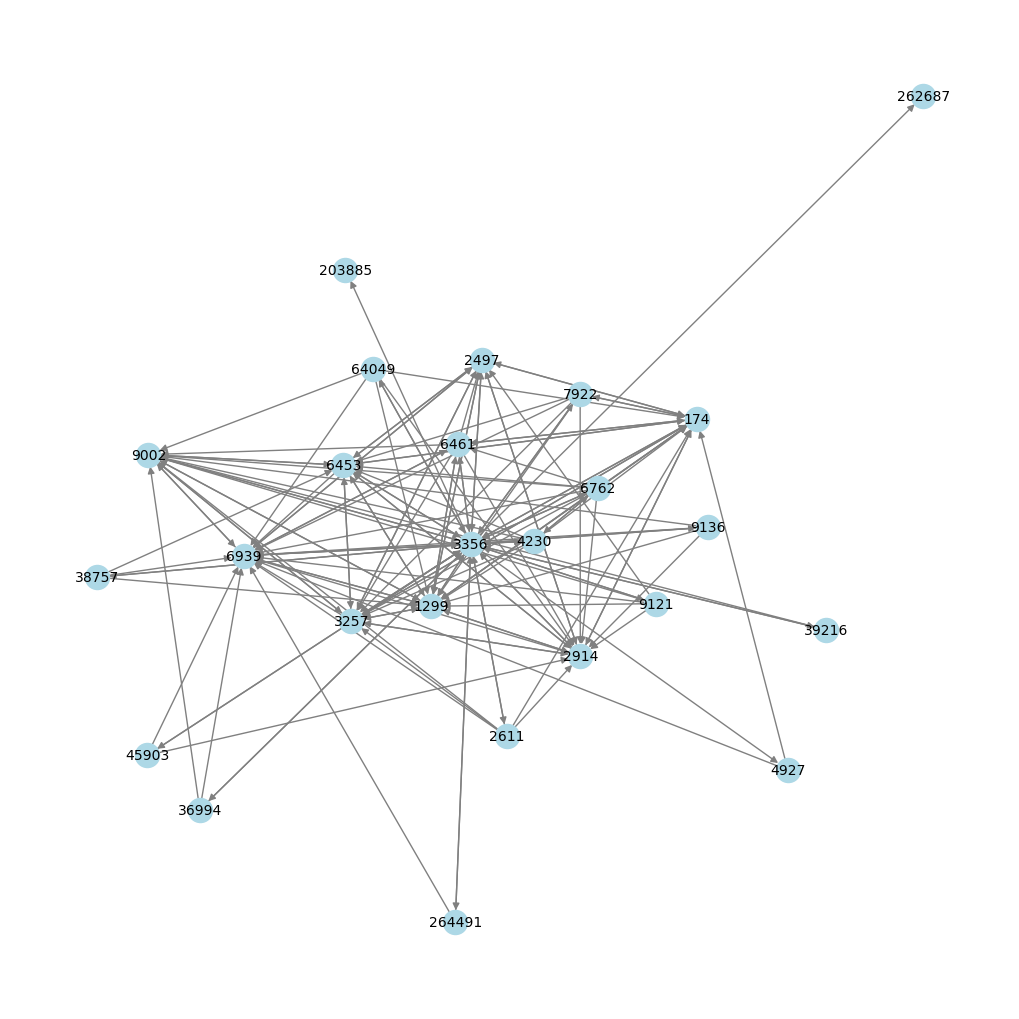

In [11]:
# test use of bgpSubgraph

test = bgpSubgraph("3356")
print(test.number_of_nodes())
print(test.number_of_edges())


pos = nx.spring_layout(test, k=1)
plt.figure(figsize=(10, 10))
nx.draw(test, pos, with_labels=True, node_color="lightblue", edge_color="gray", font_size=10, arrows=True)
plt.show()

In [12]:

import pickle

asnLocations = await fetch_until_done(bgpNetwork.nodes())

with open("asnLocationsLocalRecent.pkl", "wb") as file:
    pickle.dump(asnLocations, file)


In [13]:
import pickle

with open("asnLocationsLocalRecent.pkl", "rb") as file:
    asnLocations = pickle.load(file)

In [14]:
count = 0

for key, value in asnLocations.items():
    count += 1

print(count)

38020


In [15]:
for asn1, asn2 in bgpNetwork.edges():
    lat1, lon1 = asnLocations[asn1]
    lat2, lon2 = asnLocations[asn2]
    distances = []

    if lat1 == None or lat2 == None or lon1 == None or lon2 == None:
        distance = 4251.3269268343265
    else:
        distance = haversine(lat1, lon1,lat2, lon2)

    bgpNetwork[asn1][asn2]['weight'] = distance


In [16]:
def weightedSubgraphDisplay(x):
    testWeightedEdge = bgpSubgraph(x)
    pos = nx.spring_layout(testWeightedEdge, k=0.0001)
    plt.figure(figsize=(10, 10))
    nx.draw(testWeightedEdge, pos, with_labels=True, node_color="lightblue", edge_color="gray", font_size=10, arrows=True)
    edge_labels = nx.get_edge_attributes(testWeightedEdge, 'weight')
    nx.draw_networkx_edge_labels(testWeightedEdge, pos, edge_labels=edge_labels, font_size=8)
    plt.show()


In [17]:
# used for testing, get the values of nodes that have an existing path with each other
done = False

while not done:
    node1, node2 = random.sample(bgpNetwork.nodes(), 2)
    if nx.has_path(bgpNetwork, node1, node2):
        done = True
        break

print(f"There is a path between {node1} and {node2}")
    

There is a path between 208869 and 4826


C:\Users\Kennway\AppData\Local\Temp\ipykernel_27412\3975388977.py:5: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  node1, node2 = random.sample(bgpNetwork.nodes(), 2)


In [18]:
from collections import defaultdict
import networkx as nx

path_dict = defaultdict(list)
for path in asPathLists:
    if path:
        key = (path[0], path[-1])
        path_dict[key].append(path)

def calculate_path_distance(graph, path):
    return sum(
        graph[s][t]['weight'] for s, t in zip(path, path[1:])
        if s != t
    )

cheaperPathsToCheck = {}
expensivePathsToCheck = {}
totalChecks = 0
optimalPathsFound = 0
numberOfShorterDistances = 0
numberOfLongerDistances = 0

foundAlreadyCheap = False
foundShorterCheaper = False
foundShorterExpensive = False

listOfOptimalPaths = []


for (source, target), paths in path_dict.items():
    try:
        optimal_path = nx.shortest_path(bgpNetwork, source=source, target=target)
    except nx.NetworkXNoPath:
        continue

    smallest_existing = min(paths, key=len)

    if len(optimal_path) < len(smallest_existing):
        optimalPathsFound += 1

        current_distance = calculate_path_distance(bgpNetwork, smallest_existing)
        optimal_distance = calculate_path_distance(bgpNetwork, optimal_path)

        if current_distance > optimal_distance:
            numberOfShorterDistances += 1
            cheaperPathsToCheck[(source, target)] = (current_distance, smallest_existing, optimal_distance, optimal_path)
            if not foundShorterCheaper:
                shorterCheaper = optimal_path
                originalShorterCheaper = smallest_existing
                foundShorterCheaper = True
                listOfOptimalPaths.append(optimal_path)
        else:
            numberOfLongerDistances += 1
            expensivePathsToCheck[(source, target)] = (current_distance, smallest_existing, optimal_distance, optimal_path)
            if not foundShorterExpensive:
                shorterExpensive = optimal_path
                foundShorterExpensive = True
                listOfOptimalPaths.append(optimal_path)

        # print(f"Found shorter path for Source: {source} Target: {target}")
        # print("Current Smallest: " + str(smallest_existing))
        # print("Optimal Path: " + str(optimal_path))
    else: 
        if not foundAlreadyCheap:
            alreadyCheap = smallest_existing
            originalShorterExpensive = smallest_existing
            foundAlreadyCheap = True

    totalChecks += 1

print(f"{optimalPathsFound}/{totalChecks}")
print("Number of cheaper paths found: " + str(numberOfShorterDistances))
print("Number of longer paths found: " + str(numberOfLongerDistances))

print("Already short path: " + str(alreadyCheap))
print("Cheaper short path: " + str(shorterCheaper))
print("Original for above: " + str(originalShorterCheaper))
print("Expensive short path " + str(shorterExpensive))
print("Original for above: " + str(originalShorterExpensive))

print(listOfOptimalPaths)


110493/351994
Number of cheaper paths found: 66773
Number of longer paths found: 43720
Already short path: ['3356', '1299', '13030']
Cheaper short path: ['36884', '6453', '24482']
Original for above: ['36884', '6762', '2914', '24482']
Expensive short path ['721', '3356', '1299', '13030']
Original for above: ['3356', '1299', '13030']
[['721', '3356', '1299', '13030'], ['36884', '6453', '24482']]


In [19]:
import networkx as nx
import matplotlib.pyplot as plt
import itertools

def smallestPathsSubgraphDisplay(G, source, target, k=5):
    try:
        path_generator = nx.shortest_simple_paths(G, source, target)
        paths = list(itertools.islice(path_generator, k)) 
    except nx.NetworkXNoPath:
        print(f"No path found between {source} and {target}.")
        return

    if not paths:
        print(f"No paths found between {source} and {target}.")
        return

    subgraph_edges = set()
    for path in paths:
        subgraph_edges.update(zip(path, path[1:]))

    H = nx.DiGraph()
    H.add_edges_from(subgraph_edges)

    if H.number_of_nodes() < 300:
        pos = nx.spring_layout(H, k=0.5)
    else:
        pos = nx.kamada_kawai_layout(H)

    plt.figure(figsize=(12, 10))
    nx.draw(H, pos, with_labels=True, node_color="lightblue", edge_color="gray", font_size=10, arrows=True)

    edge_attrs = nx.get_edge_attributes(G, 'weight')
    if edge_attrs:
        relevant_labels = {(u, v): edge_attrs[(u, v)] for (u, v) in H.edges() if (u, v) in edge_attrs}
        nx.draw_networkx_edge_labels(H, pos, edge_labels=relevant_labels, font_size=8)

    plt.title(f"{len(paths)} shortest paths from {source} to {target}")
    plt.show()

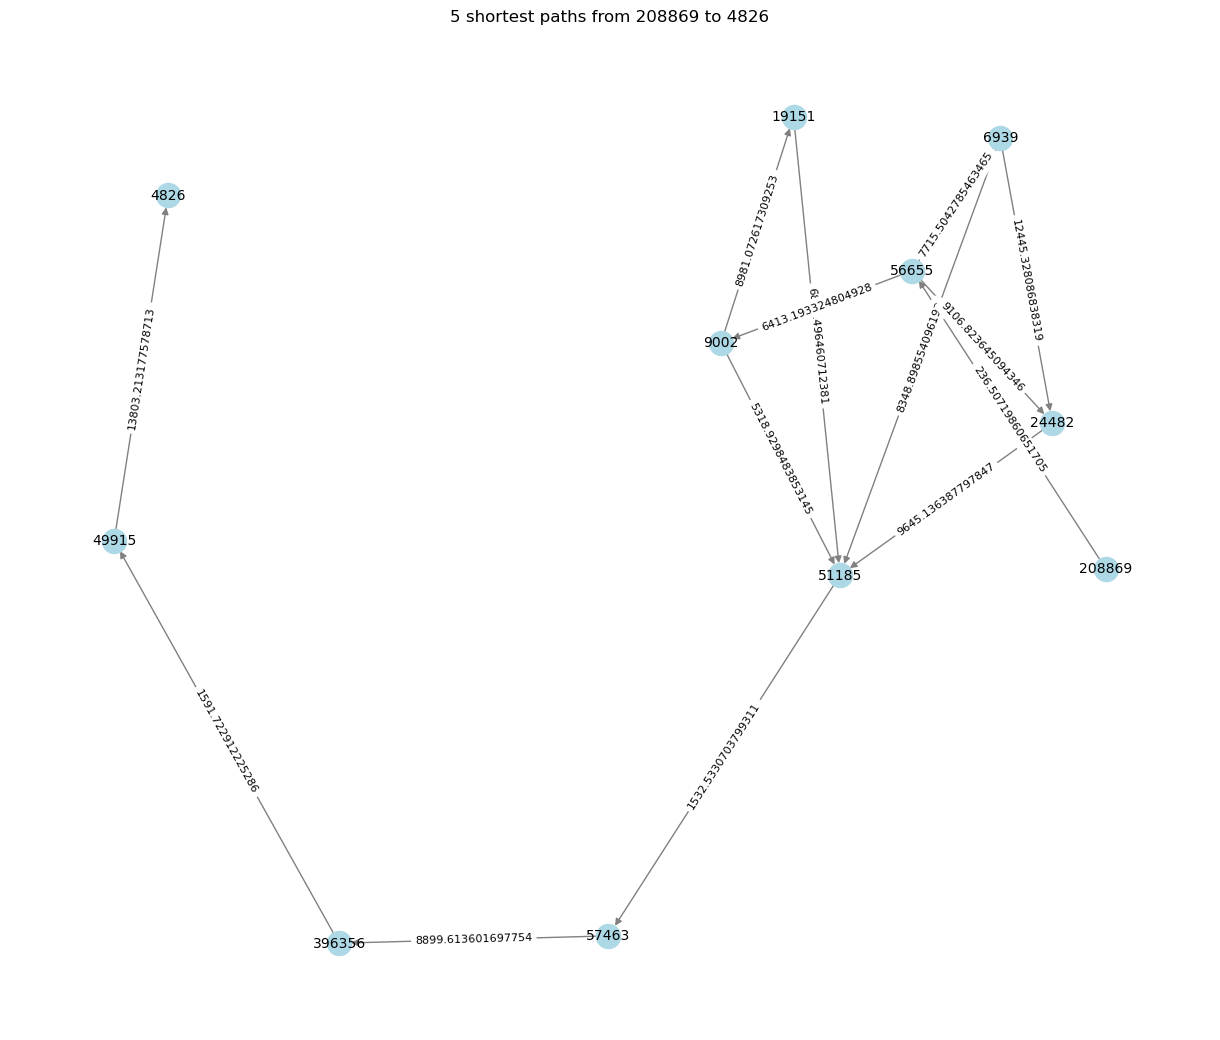

In [21]:
smallestPathsSubgraphDisplay(bgpNetwork, '208869','4826')

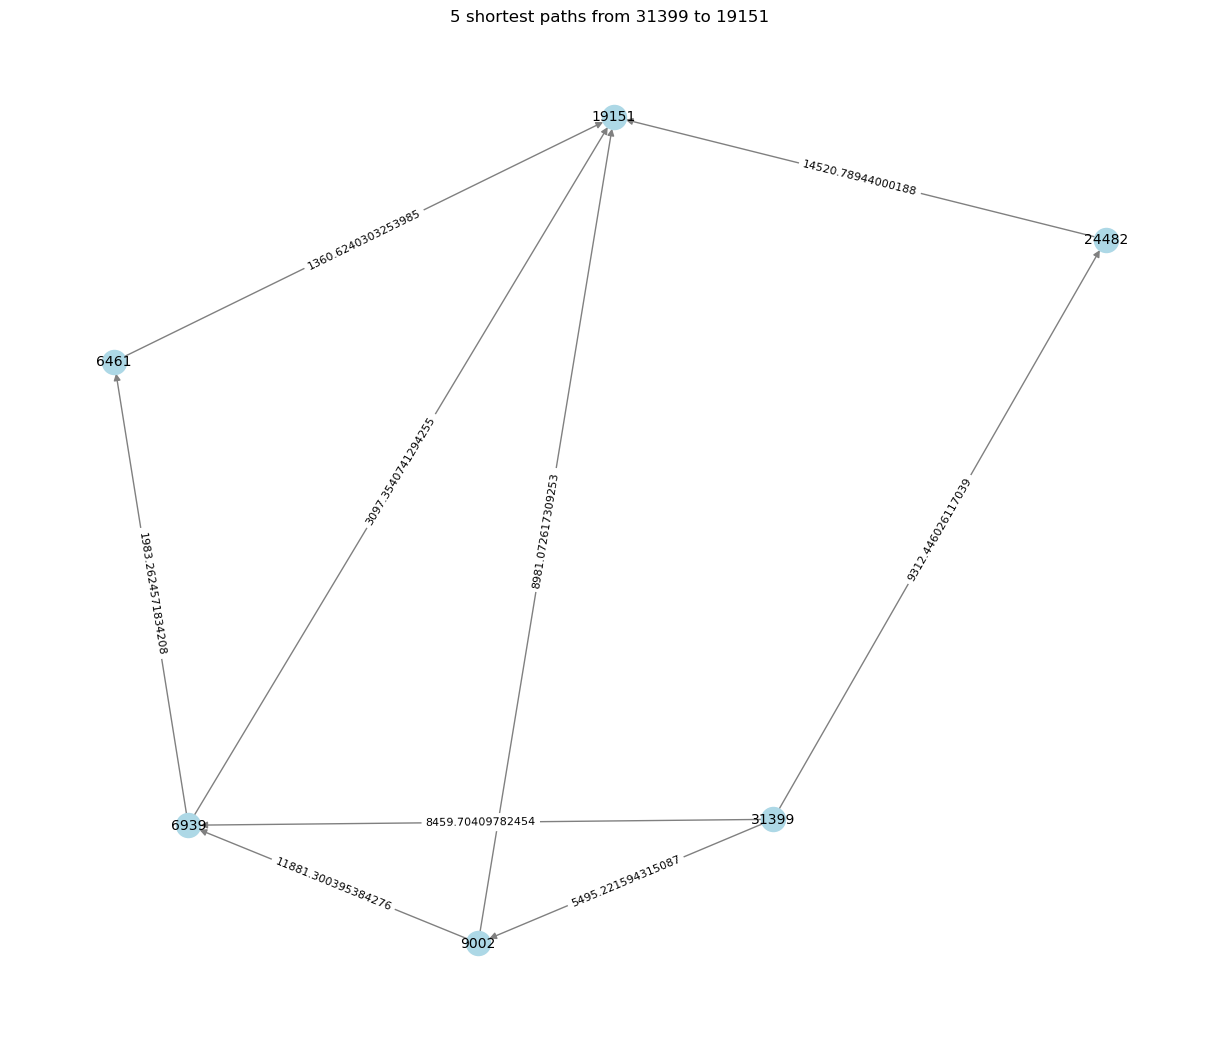

In [22]:
smallestPathsSubgraphDisplay(bgpNetwork, '31399','19151')

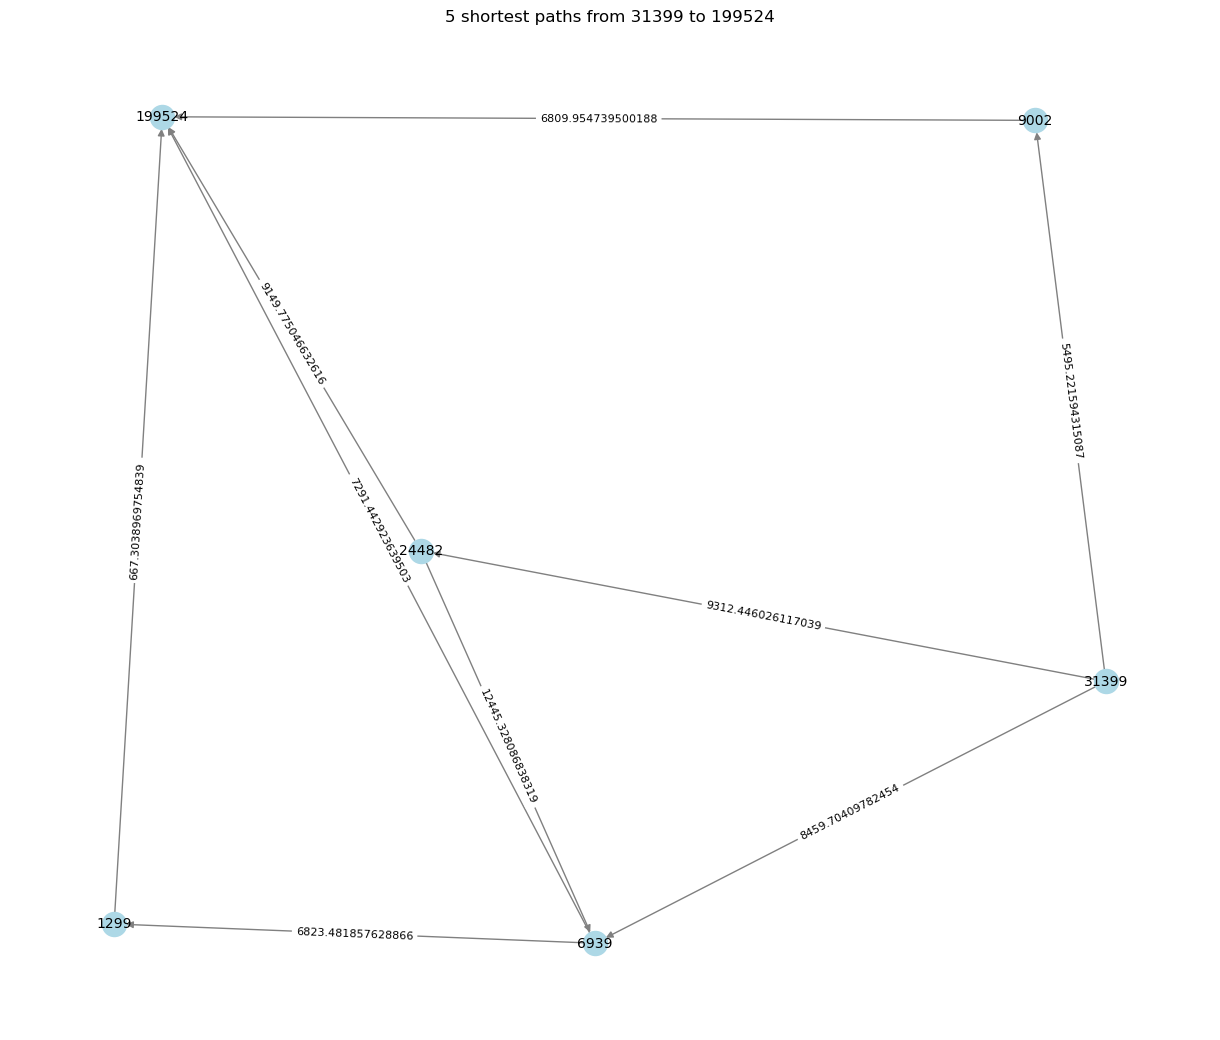

In [ ]:
smallestPathsSubgraphDisplay(bgpNetwork, '31399','199524')

In [23]:
for key, value in list(cheaperPathsToCheck.items())[:10]:
    print(key, value)

('36884', '24482') (21325.818006674737, ['36884', '6762', '2914', '24482'], 16271.325002199788, ['36884', '6453', '24482'])
('7303', '19151') (15492.539442204596, ['7303', '3356', '2914', '19151'], 13143.469433191069, ['7303', '6939', '19151'])
('7303', '24482') (30527.46101014313, ['7303', '6762', '2914', '24482'], 22491.44344589996, ['7303', '6939', '24482'])
('11830', '9304') (19420.956601112164, ['11830', '3356', '3257', '9304'], 18981.096219358093, ['11830', '6762', '9304'])
('30722', '199524') (3100.977497797348, ['30722', '1273', '1299', '199524'], 2902.950439354889, ['30722', '1299', '199524'])
('3269', '9304') (19771.9728527962, ['3269', '6762', '174', '9304'], 10060.934416749029, ['3269', '6762', '9304'])
('5378', '9304') (18259.247095523766, ['5378', '1273', '174', '9304'], 10936.26943799057, ['5378', '24482', '9304'])
('47377', '24482') (21631.11495104486, ['47377', '3356', '2914', '24482'], 20514.778417232024, ['47377', '6939', '24482'])
('29465', '13030') (29090.047255573

In [24]:
def get_tier(asn):
    url = f"https://api.asrank.caida.org/v2/restful/asns/{asn}"
    try:
        response = requests.get(url, timeout=5)
        if response.status_code == 200:
            data = response.json().get('data', {}).get('asn', {})
            degrees = data.get('asnDegree', {})
            provider = degrees.get('provider', 0)
            peer = degrees.get('peer', 0)
            customer = degrees.get('customer', 0)
            total = degrees.get('total', 0)
            rank = data.get("rank", float('inf'))
            clique = data.get("cliqueMember", False)

            # Tier 1
            if clique and provider == 0 and customer > 1:
                return 1

            # Tier 3: 
            elif provider > 0 and customer == 0 and peer == 0:
                return 3

            # Tier 2
            elif peer > 1 and provider > 0:
                return 2
    except Exception as e:
        print(f"Error ASN {asn}: {e}")
    return None


In [25]:
# label
tier_labels = {}
for asn in df.index[:300]:  # labeling 300 for now
    tier = get_tier(asn)
    if tier:
        tier_labels[asn] = tier

df['tier'] = df.index.map(tier_labels)

 # todo check how many dropped
df = df.dropna(subset=['tier'])
df['tier'] = df['tier'].astype(int)

print(df['tier'].value_counts())


2    186
3     35
1     17
Name: tier, dtype: int64


In [26]:
#sus?
# 70% training, 30 testing 

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X = df[['out_degree', 'in_degree', 'degree_centrality', 'closeness_centrality']]
y = df['tier']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# train 
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# make prediction
y_pred = model.predict(X_test)

#compare predicton to actual label 
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.38      0.60      0.46         5
           2       0.94      0.88      0.91        56
           3       0.83      0.91      0.87        11

    accuracy                           0.86        72
   macro avg       0.72      0.79      0.75        72
weighted avg       0.89      0.86      0.87        72



In [27]:
unique = df.index.unique()
print(f"Unique: {len(unique)}")



Unique: 238


In [28]:
# class weight balanced

# 70% training, 30 testing 

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X = df[['out_degree', 'in_degree', 'degree_centrality', 'closeness_centrality']]
y = df['tier']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# train 
model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# make prediction
y_pred = model.predict(X_test)

#compare predicton to actual label 
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.38      0.60      0.46         5
           2       0.94      0.86      0.90        56
           3       0.77      0.91      0.83        11

    accuracy                           0.85        72
   macro avg       0.70      0.79      0.73        72
weighted avg       0.88      0.85      0.86        72



In [29]:
# 70% training, 30% testing

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Feature matrix and labels
X = df[['out_degree', 'in_degree', 'degree_centrality', 'closeness_centrality']]
y = df['tier']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced']
}

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=2,
    scoring='f1_macro',
    n_jobs=-1
)

# Fit model
grid_search.fit(X_train, y_train)

# Use best model found
model = grid_search.best_estimator_

# Make predictions
y_pred = model.predict(X_test)

# Compare prediction to actual label
print(classification_report(y_test, y_pred))
print("Best hyperparameters:", grid_search.best_params_)

              precision    recall  f1-score   support

           1       0.38      0.60      0.46         5
           2       0.94      0.86      0.90        56
           3       0.77      0.91      0.83        11

    accuracy                           0.85        72
   macro avg       0.70      0.79      0.73        72
weighted avg       0.88      0.85      0.86        72

Best hyperparameters: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}


In [30]:
# 70% training, 30% testing

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

# Feature matrix and labels
X = df[['out_degree', 'in_degree', 'degree_centrality', 'closeness_centrality']]
y = df['tier'] - 1


# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# Define hyperparameter grid for XGBoost
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(
    estimator=XGBClassifier(
        eval_metric='mlogloss',
        objective='multi:softmax',  # Predict tier labels directly
        random_state=42
    ),
    param_grid=param_grid,
    cv=2,
    scoring='f1_macro',
    n_jobs=-1
)

# Fit model
grid_search.fit(X_train, y_train)

# Use best model found
model = grid_search.best_estimator_

# Make predictions
y_pred = model.predict(X_test)

# Compare prediction to actual label
print(classification_report(y_test, y_pred))
print("Best hyperparameters:", grid_search.best_params_)

              precision    recall  f1-score   support

           0       0.43      0.60      0.50         5
           1       0.94      0.91      0.93        56
           2       0.91      0.91      0.91        11

    accuracy                           0.89        72
   macro avg       0.76      0.81      0.78        72
weighted avg       0.90      0.89      0.89        72

Best hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}


In [31]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from lightgbm import LGBMClassifier

# Feature matrix and adjusted labels (optional: subtract 1 for consistency with other models)
X = df[['out_degree', 'in_degree', 'degree_centrality', 'closeness_centrality']]
y = df['tier']  # No need to subtract 1 for LGBM

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# Hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1],
    'class_weight': ['balanced']
}

# Grid search
grid_search = GridSearchCV(
    estimator=LGBMClassifier(random_state=42),
    param_grid=param_grid,
    cv=2,  # safer for small classes
    scoring='f1_macro',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
model = grid_search.best_estimator_

# Predict + report
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print("Best hyperparameters:", grid_search.best_params_)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 139
[LightGBM] [Info] Number of data points in the train set: 166, number of used features: 4
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

In [32]:
def smallestPathsSubgraphDisplay_with_original(G, source, target, df, asPathLists, k=5):
    try:
        path_generator = nx.shortest_simple_paths(G, source, target)
        paths = list(itertools.islice(path_generator, k)) 
    except nx.NetworkXNoPath:
        print(f"No path found between {source} and {target}.")
        return

    if not paths:
        print(f"No paths found between {source} and {target}.")
        return

    subgraph_edges = set()
    for path in paths:
        subgraph_edges.update(zip(path, path[1:]))

    H = nx.DiGraph()
    H.add_edges_from(subgraph_edges)

    # Find the original path (first match from your BGP data)
    original_path = None
    for path in asPathLists:
        if path and path[0] == source and path[-1] == target:
            original_path = path
            break

    optimalPath = None
    for path in listOfOptimalPaths:
        if path and path[0] == source and path[-1] == target:
            optimalPath = path
            break

    original_edges = set()
    if original_path:
        original_edges = set(zip(original_path, original_path[1:]))
    
    H.add_edges_from(original_edges)

    optimalEdges = set()
    if optimalPath:
        optimalEdges = set(zip(optimalPath, optimalPath[1:]))

    if H.number_of_nodes() < 300:
        pos = nx.spring_layout(H, k=0.5)
    else:
        pos = nx.kamada_kawai_layout(H)

    plt.figure(figsize=(12, 10))

    # Build labels with Tier info
    custom_labels = {}
    for node in H.nodes():
        if node in df.index:
            tier = df.loc[node, 'tier']
            custom_labels[node] = f"{node}\nTier {tier}"
        else:
            custom_labels[node] = str(node)

    # Set edge colors
    edge_colors = []
    for u, v in H.edges():
        if (u, v) in original_edges:
            edge_colors.append('red')  # highlight original path edges
        elif (u, v) in optimalEdges:
            edge_colors.append('green')
        else:
            edge_colors.append('gray')  # normal edges

    nx.draw(
        H, pos, labels=custom_labels,
        node_color="lightblue", edge_color=edge_colors,
        font_size=8, arrows=True
    )

    # Edge labels (distances)
    edge_attrs = nx.get_edge_attributes(G, 'weight')
    if edge_attrs:
        relevant_labels = {(u, v): edge_attrs[(u, v)] for (u, v) in H.edges() if (u, v) in edge_attrs}
        nx.draw_networkx_edge_labels(H, pos, edge_labels=relevant_labels, font_size=8)

    plt.title(f"{len(paths)} shortest paths from {source} to {target}\n(Red = original BGP path)")
    plt.show()


In [33]:
def weightedSubgraphDisplay_with_tiers(x, df):
    testWeightedEdge = bgpSubgraph(x)
    pos = nx.spring_layout(testWeightedEdge, k=0.0001)
    plt.figure(figsize=(10, 10))
    
    # Build labels with Tier info
    custom_labels = {}
    for node in testWeightedEdge.nodes():
        if node in df.index:
            tier = df.loc[node, 'tier']
            custom_labels[node] = f"{node}\nTier {tier}"
        else:
            custom_labels[node] = str(node)  # fallback if no tier info

    nx.draw(
        testWeightedEdge, pos, labels=custom_labels,
        node_color="lightblue", edge_color="gray", font_size=8, arrows=True
    )

    edge_labels = nx.get_edge_attributes(testWeightedEdge, 'weight')
    nx.draw_networkx_edge_labels(testWeightedEdge, pos, edge_labels=edge_labels, font_size=8)

    plt.title(f"Subgraph around ASN {x}")
    plt.show()


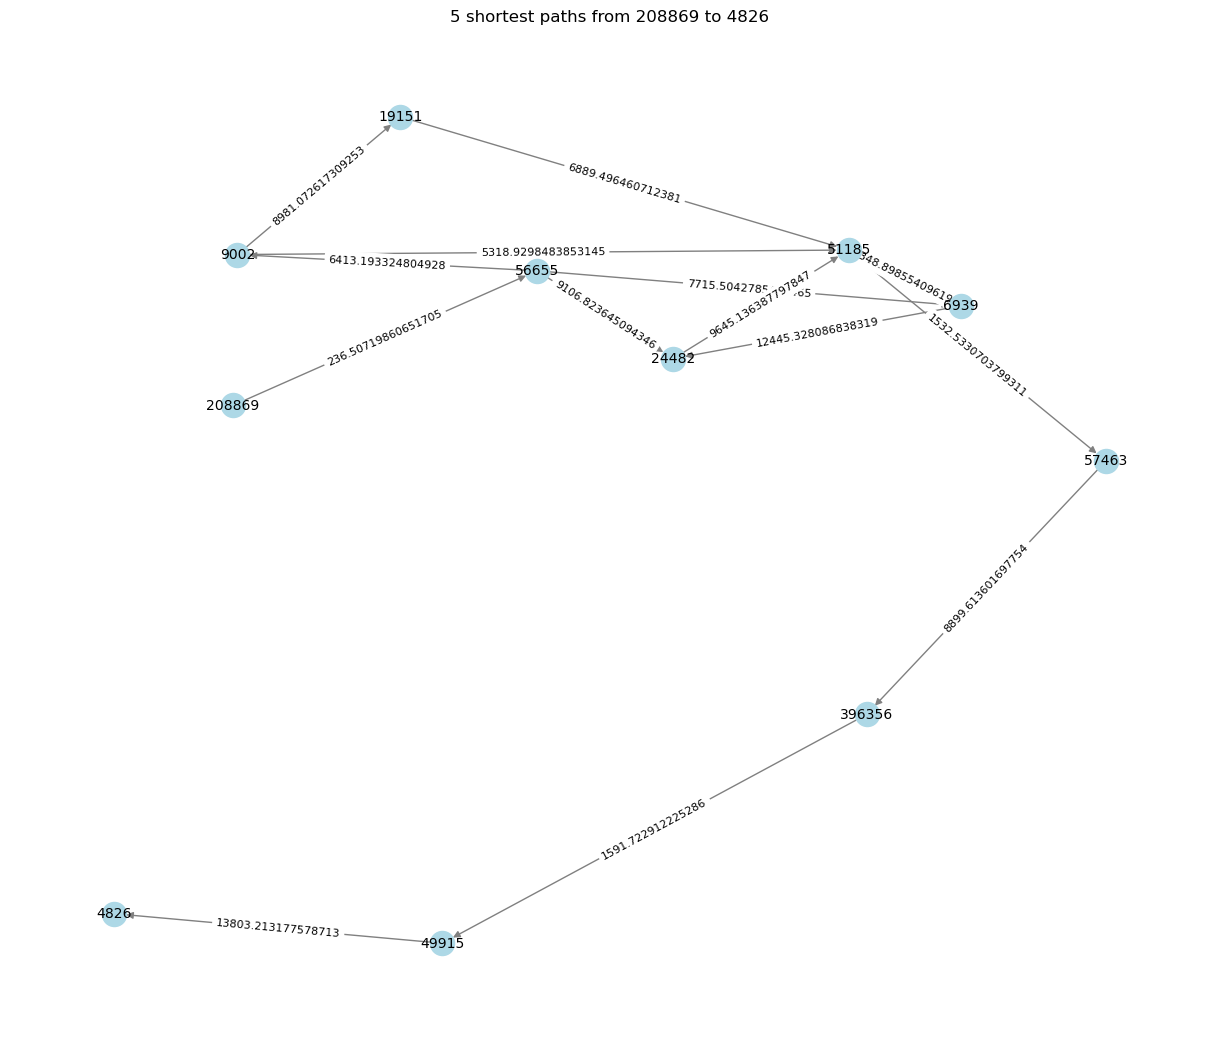

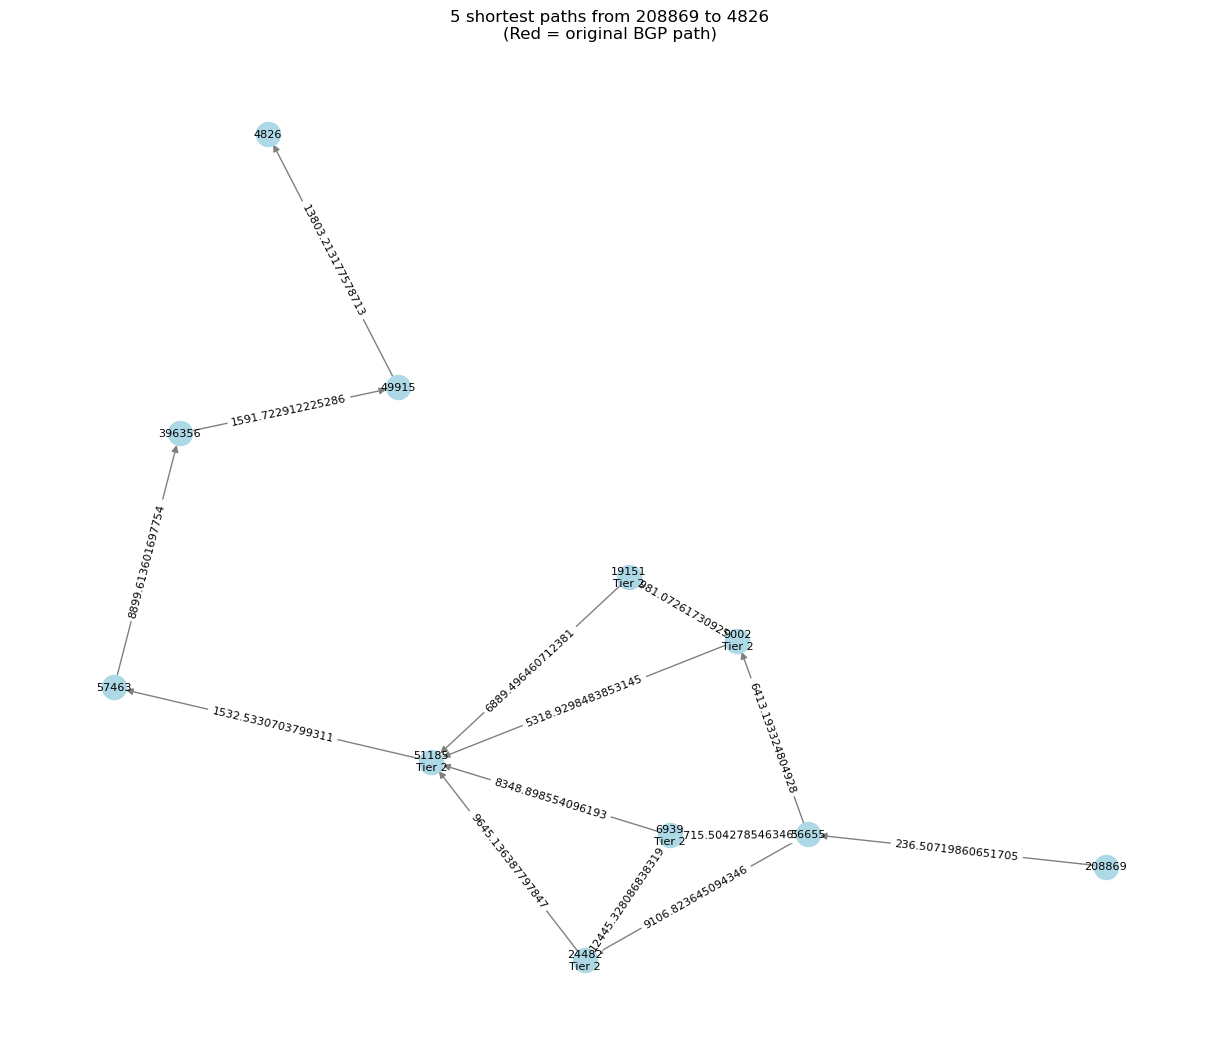

In [35]:
smallestPathsSubgraphDisplay(bgpNetwork, '208869','4826') 
smallestPathsSubgraphDisplay_with_original(bgpNetwork, '208869','4826', df, asPathLists)

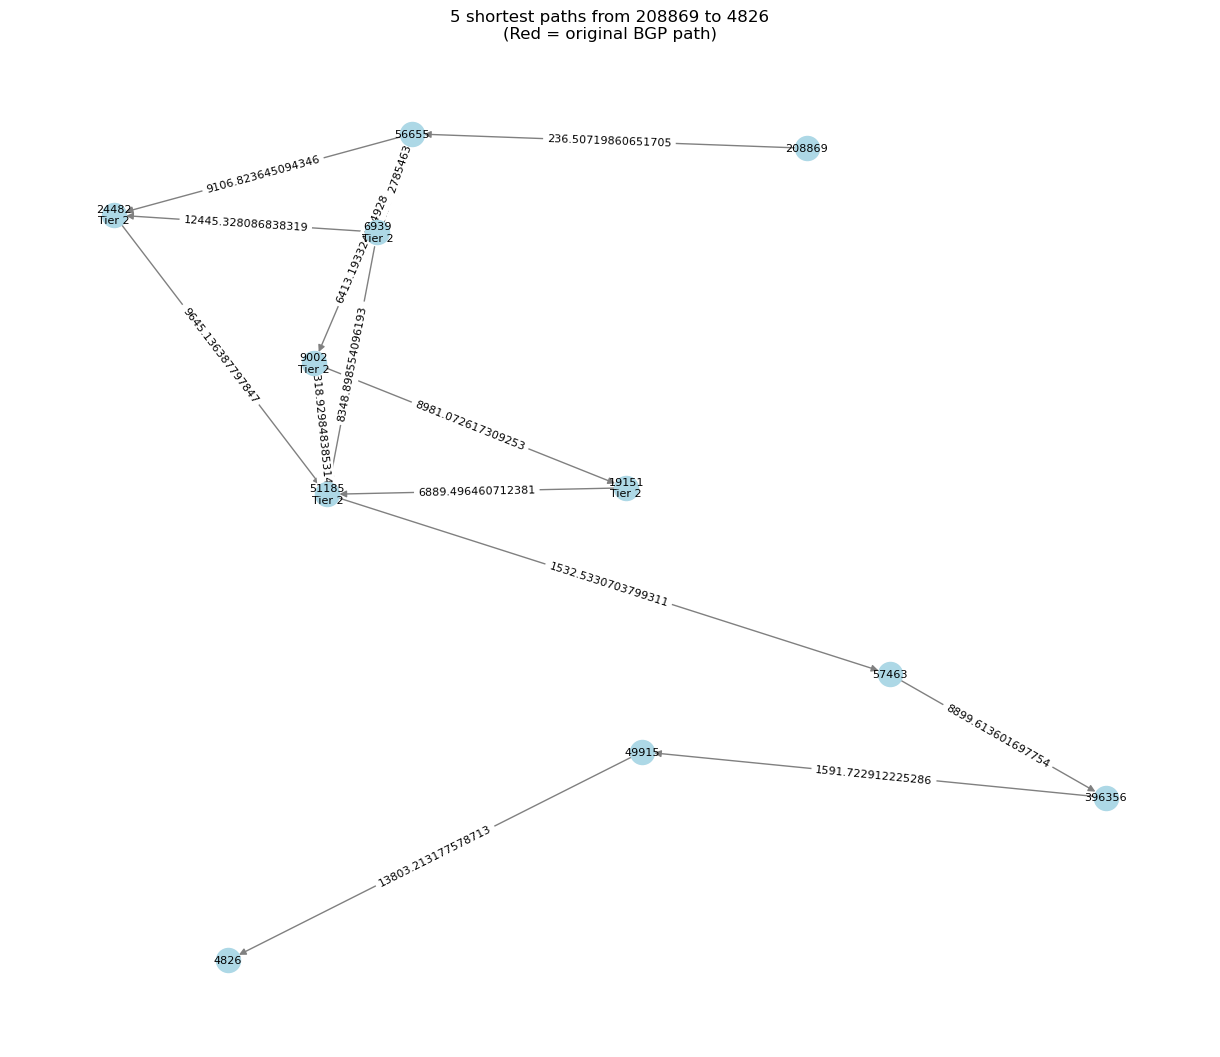

In [36]:
smallestPathsSubgraphDisplay_with_original(bgpNetwork, '208869','4826', df, asPathLists)